In [188]:
# testing out issues with mps
import torch
import platform
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


print("Python:", platform.python_version())
print("macOS:", platform.mac_ver())
print("Machine:", platform.machine())
print("MPS Built:", torch.backends.mps.is_built())
print("MPS Available:", torch.backends.mps.is_available())
print("Torch Version:", torch.__version__)


Python: 3.10.13
macOS: ('13.6', ('', '', ''), 'arm64')
Machine: arm64
MPS Built: True
MPS Available: True
Torch Version: 2.2.2


In [189]:
#loading packages and our data
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
       

# Load the data
pop = pd.read_csv('data/songs_kword_LIWC.csv')
pop.columns

Index(['title', 'artist', 'lyrics', 'num_days', 'avg_pos', 'max_pos',
       'Segment', 'WC', 'Analytic', 'Clout',
       ...
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark', 'Exclam',
       'Apostro', 'OtherP', 'Emoji'],
      dtype='object', length=125)

In [190]:
# processing: currently leaving punctuation alone
#note: sometimes this needs loaded twice
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

pop['lyrics'] = pop['lyrics'].astype(str).apply(remove_stopwords)
pop['lyrics-tokenized'] = pop['lyrics'].apply(simple_preprocess)


In [191]:
# # emotion detection with distilroberta
# # https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
# # Load model and tokenizer

# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


# from transformers import pipeline
# emotion_model = pipeline(
#     "text-classification",
#     model="j-hartmann/emotion-english-distilroberta-base",
#     truncation=True 
# )

# # Process the entire column in batch (more efficient than applying row by row)
# predictions = emotion_model(pop['lyrics'].tolist(), batch_size=8)

In [192]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

# Ensure MPS is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Load model and tokenizer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()
id2label = model.config.id2label

# Define chunking function
def chunk_text(text, tokenizer, max_length=512, stride=256):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    chunks = []
    for i in range(0, len(input_ids), stride):
        chunk = input_ids[i:i+max_length]
        if len(chunk) < 5:
            continue
        chunks.append(chunk)
        if i + max_length >= len(input_ids):
            break
    return chunks

# Get lyrics list
lyrics_list = pop['lyrics'].astype(str).tolist()

# Process lyrics
all_labels = []
all_scores = []

with torch.no_grad():
    for lyric in lyrics_list:
        token_chunks = chunk_text(lyric, tokenizer)
        emotions = []
        scores = []

        for chunk in token_chunks:
            input_tensor = torch.tensor([chunk]).to(device)
            attention_mask = torch.ones_like(input_tensor).to(device)
            outputs = model(input_ids=input_tensor, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=-1)
            pred_idx = torch.argmax(probs, dim=1).item()
            emotions.append(id2label[pred_idx])
            scores.append(probs[0, pred_idx].item())

        if emotions:
            most_common_emotion = pd.Series(emotions).mode().iloc[0]
            avg_score = sum(scores) / len(scores)
        else:
            most_common_emotion = None
            avg_score = None

        all_labels.append(most_common_emotion)
        all_scores.append(avg_score)

# Add predictions to DataFrame
pop['emotion'] = all_labels
pop['emotion_score'] = all_scores


Token indices sequence length is longer than the specified maximum sequence length for this model (1116 > 512). Running this sequence through the model will result in indexing errors


In [193]:
# # Add to DataFrame  
pop['emotion'] = all_labels
pop['emotion_score'] = all_scores

# Optional: create one-hot-style score columns for each emotion
for emotion in set(all_labels):
    pop[emotion] = pop.apply(lambda row: row['emotion_score'] if row['emotion'] == emotion else 0, axis=1)


In [194]:
# add NRC
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
import re
import string
from nrclex import NRCLex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

stop_words = set(stopwords.words('english'))

# Define cleaner
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove text in brackets (e.g., [Chorus])
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

# Emotion analysis function
def analyze_emotion(text):
    cleaned = clean_text(text)
    if cleaned:
        emotion_lexicon = NRCLex(cleaned)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {}

# Apply to your DataFrame
pop['emotion_scores_nrc'] = pop['lyrics'].apply(analyze_emotion)


In [195]:
# Math on what we have/identifying possible issues

# Total rows
total_rows = pop.shape[0]

# Count of valid dicts
valid_dicts = pop['emotion_scores_nrc'].apply(lambda x: isinstance(x, dict) and len(x) > 0).sum()

# Count of empty dicts
empty_dicts = pop['emotion_scores_nrc'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()

# Count of NaNs or None
null_values = pop['emotion_scores_nrc'].isna().sum()

# Summary
print(f"Total rows: {total_rows}")
print(f"Valid emotion dicts: {valid_dicts}")
print(f"Empty emotion dicts: {empty_dicts}")
print(f"Missing (NaN/None): {null_values}")
print(f"Total accounted for: {valid_dicts + empty_dicts + null_values}")


Total rows: 9291
Valid emotion dicts: 9282
Empty emotion dicts: 9
Missing (NaN/None): 0
Total accounted for: 9291


In [196]:
# from bertopic import BERTopic
# from umap import UMAP
# import hdbscan
# import pandas as pd

# # Prepare lyrics data
# lyrics = pop['lyrics'].dropna().astype(str).tolist()

# # Custom UMAP for more refined topic separation
# umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# # HDBSCAN with prediction_data enabled
# hdbscan_model = hdbscan.HDBSCAN(
#     min_cluster_size=10,
#     min_samples=1,
#     metric='euclidean',
#     cluster_selection_method='eom',
#     prediction_data=True  # 🛠️ Required for probabilities
# )

# # Create and fit BERTopic model
# topic_model = BERTopic(
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     calculate_probabilities=True,
#     verbose=True
# )

# # Fit model
# topics, probs = topic_model.fit_transform(lyrics)

# # Assign topics to dataframe
# pop['topic'] = topics

# # Show topic info
# print(topic_model.get_topic_info())


In [197]:
from nrclex import NRCLex

# Define NRC emotion analyzer
def analyze_emotion(text):
    if isinstance(text, str):
        emotion_lexicon = NRCLex(text)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {}

# Apply NRC analysis to lyrics
pop['emotion_scores_nrc'] = pop['lyrics'].apply(analyze_emotion)

# Convert dictionary of emotions to DataFrame
emotion_df = pop['emotion_scores_nrc'].apply(pd.Series).fillna(0)

# Define expected NRC columns
nrc_cols = ['anger_nrc', 'fear_nrc', 'joy_nrc', 'sadness_nrc', 'surprise_nrc',
            'disgust_nrc', 'trust_nrc', 'anticipation_nrc', 'negative_nrc', 'positive_nrc']

# Ensure emotion_df has all expected columns (even if some are missing from raw scores)
for col in nrc_cols:
    if col not in emotion_df.columns:
        emotion_df[col] = 0

# Reorder columns and drop existing NRC columns from pop if they exist
emotion_df = emotion_df[nrc_cols]
pop = pop.drop(columns=[col for col in nrc_cols if col in pop.columns])

# Add NRC emotion scores to pop
pop[nrc_cols] = emotion_df


In [198]:
# now LIWC, NRC, distilbert all together : time for Factor Analysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

pop_num = pop.select_dtypes(include='number')

# NEED TO LOOK AT THIS RE  NA VALUES 
pop_num_clean = pop_num.dropna() 
print(f"Rows before: {pop_num.shape[0]}, after dropna: {pop_num_clean.shape[0]}")
pop_num_clean = pop_num_clean.loc[:, pop_num_clean.std() != 0]
print((pop_num_clean.std() == 0).sum()) 


chi_square_value,p_value=calculate_bartlett_sphericity(pop_num_clean)
chi_square_value, p_value

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
# https://www.datacamp.com/tutorial/introduction-factor-analysis

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(pop_num_clean)
print("kmo: ", kmo_model) # nan--issues



Rows before: 9291, after dropna: 9231
0
kmo:  nan


/opt/miniconda3/envs/tswift-mps/lib/python3.10/site-packages/factor_analyzer/factor_analyzer.py:118: RuntimeWarning:

divide by zero encountered in log

/opt/miniconda3/envs/tswift-mps/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:1539: RuntimeWarning:

invalid value encountered in subtract

/opt/miniconda3/envs/tswift-mps/lib/python3.10/site-packages/factor_analyzer/utils.py:205: RuntimeWarning:

invalid value encountered in sqrt



In [199]:
# too many columns and not ready for factor analysis
from sklearn.feature_selection import VarianceThreshold

# Remove columns with zero or near-zero variance
selector = VarianceThreshold(threshold=1e-5)
filtered_data = selector.fit_transform(pop_num_clean)

# Optionally get remaining column names
remaining_cols = pop_num_clean.columns[selector.get_support()]
pop_num_filtered = pd.DataFrame(filtered_data, columns=remaining_cols)
pop_num_filtered.drop("Segment", inplace=True, axis=1, errors='ignore')

#note had to edit error = sp. in factor analyzer.py to error = np. 


In [200]:
# identify low-loading factors to remove
from factor_analyzer import FactorAnalyzer

# Perform Factor Analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(pop_num_filtered)

# Get factor loadings
loadings = fa.loadings_

# Set a threshold for removing low loadings
threshold = 0.4

# Identify columns (items) with low factor loadings
low_loading_items = [pop_num_clean.columns[i] for i in range(loadings.shape[0]) if all(abs(loadings[i, :]) < threshold)]

print(f"Items with low factor loadings (below {threshold}):")
print(low_loading_items)

# Remove those items from the original DataFrame
pop_num_concise = pop_num_clean.drop(columns=low_loading_items)

# Check the cleaned dataset
print(f"DataFrame after removing low loading items: {pop_num_concise.shape}")

print(f"Remaining columns after removing low loading items: {pop_num_concise.columns.tolist()}")


Items with low factor loadings (below 0.4):
['num_days', 'avg_pos', 'max_pos', 'Segment', 'Analytic', 'Authentic', 'Tone', 'WPS', 'ppron', 'i', 'you', 'shehe', 'they', 'ipron', 'article', 'number', 'adverb', 'conj', 'verb', 'adj', 'quantity', 'Drives', 'affiliation', 'achieve', 'Cognition', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certitude', 'differ', 'memory', 'Affect', 'tone_pos', 'tone_neg', 'emo_pos', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'Social', 'socbehav', 'prosocial', 'polite', 'conflict', 'moral', 'socrefs', 'family', 'friend', 'female', 'male', 'Culture', 'politic', 'ethnicity', 'tech', 'Lifestyle', 'leisure', 'home', 'work', 'money', 'relig', 'Physical', 'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 'food', 'death', 'need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue', 'reward', 'risk', 'curiosity', 'Perception', 'attention', 'space', 'visual', 'auditory', 'feeling', 'time', 'focuspast', 'focuspresent', 'Conversation', 'netspeak'

In [201]:
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Set threshold and number of factors
threshold = 0.25
n_factors = 2

# Standardize the data
scaler = StandardScaler()
pop_scaled = scaler.fit_transform(pop_num_filtered)

# Convert back to DataFrame to keep column names
pop_scaled_df = pd.DataFrame(pop_scaled, columns=pop_num_filtered.columns)

# Work on a copy for iterative elimination
pop_num_concise = pop_scaled_df.copy()

for round_num in range(1, 6):  # Run 5 rounds
    print(f"\n--- Round {round_num} ---")

    # Fit Factor Analysis
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(pop_num_concise)

    # Get loadings
    loadings = fa.loadings_

    # Identify low-loading items
    low_loading_items = [
        pop_num_concise.columns[i]
        for i in range(loadings.shape[0])
        if all(abs(loadings[i, :]) < threshold)
    ]

    print(f"Low-loading items (below {threshold}): {low_loading_items}")

    # Drop low-loading items
    pop_num_concise.drop(columns=low_loading_items, inplace=True)

    print(f"Remaining columns after round {round_num}: {pop_num_concise.columns.tolist()}")






--- Round 1 ---
Low-loading items (below 0.25): ['num_days', 'avg_pos', 'max_pos', 'Clout', 'Tone', 'WPS', 'BigWords', 'we', 'shehe', 'they', 'ipron', 'number', 'adj', 'quantity', 'Drives', 'affiliation', 'achieve', 'power', 'allnone', 'cause', 'certitude', 'memory', 'Affect', 'tone_pos', 'tone_neg', 'emo_pos', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'prosocial', 'polite', 'conflict', 'moral', 'family', 'friend', 'female', 'male', 'Culture', 'politic', 'ethnicity', 'tech', 'Lifestyle', 'leisure', 'home', 'work', 'money', 'relig', 'Physical', 'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 'food', 'death', 'need', 'acquire', 'lack', 'fulfill', 'fatigue', 'reward', 'risk', 'curiosity', 'allure', 'attention', 'motion', 'visual', 'auditory', 'feeling', 'focusfuture', 'nonflu', 'filler', 'Period', 'QMark', 'Exclam', 'emotion_score', 'surprise', 'fear', 'anger', 'joy', 'neutral', 'disgust']
Remaining columns after round 1: ['WC', 'Analytic', 'Authentic', 'Dic', 'Lin

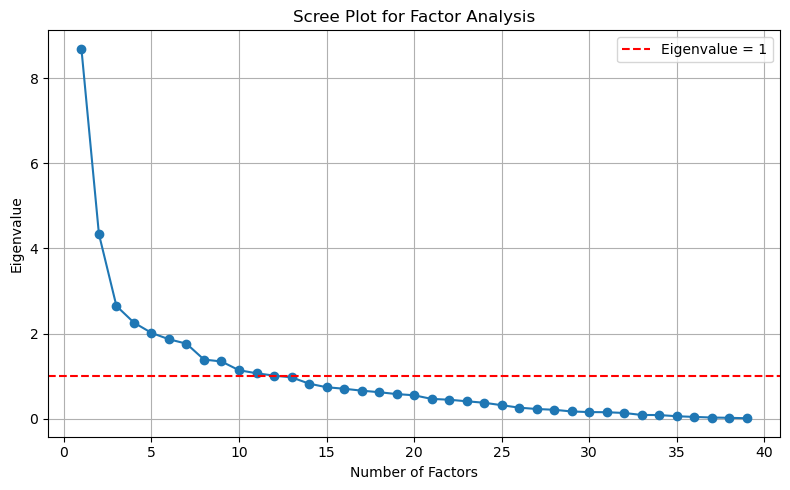

In [202]:
# determine the number of factors
# 
import matplotlib.pyplot as plt

# Fit FactorAnalyzer with max possible factors
fa = FactorAnalyzer(n_factors=pop_num_concise.shape[1], rotation='varimax')
fa.fit(pop_num_concise)

# Get eigenvalues and plot them
ev, _ = fa.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev)+1), ev, marker='o', linestyle='-')
plt.axhline(1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot for Factor Analysis')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [203]:
# Prepare for Factor Analysis on the smaller set of columns
# redo our calculations:
pop_num_concise = pop_num_clean[['Analytic', 'Linguistic',  'Cognition', 'swear', 'WC']].dropna()
#print(pop_num_concise.corr())
pop_num_concise = pop_num_concise.dropna()
#pop_num_concise.drop("Segment", axis=1, inplace=True)

#does it do better than identity matrix?
chi_square_value, p_value = calculate_bartlett_sphericity(pop_num_concise)
print("Bartlett’s Test: p =", p_value, "Chi-square =", chi_square_value)

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
# https://www.datacamp.com/tutorial/introduction-factor-analysis

#KMO calculations
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(pop_num_concise)
kmo_model # 0.6 is not very good, 0.7 is acceptable, 0.8 is good, 0.9 is great
# https://bookdown.org/luguben/EFA_in_R/kaiser-meyer-olkin-kmo.html

Bartlett’s Test: p = 0.0 Chi-square = 9699.270714028871


0.6854524050167182

In [204]:
# # determine the number of factors
# # 
# import matplotlib.pyplot as plt

# # Fit FactorAnalyzer with max possible factors
# fa = FactorAnalyzer(n_factors=pop_num_concise.shape[1], rotation='varimax')
# fa.fit(pop_num_concise)

# # Get eigenvalues and plot them
# ev, _ = fa.get_eigenvalues()

# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(ev)+1), ev, marker='o', linestyle='-')
# plt.axhline(1, color='red', linestyle='--', label='Eigenvalue = 1')
# plt.title('Scree Plot for Factor Analysis')
# plt.xlabel('Number of Factors')
# plt.ylabel('Eigenvalue')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [205]:
# ready for factor analysis:
# redo but limit to 2 factors
fa = FactorAnalyzer(n_factors=2, rotation='varimax') 
fa.fit(pop_num_concise)

# Get the variance explained
variance, proportion_variance, cumulative_variance = fa.get_factor_variance()

# Print variance results
print("Variance per factor:", variance)
print("Proportion of variance per factor:", proportion_variance)
print("Cumulative variance (proportion):", cumulative_variance)


Variance per factor: [1.60431858 0.86264422]
Proportion of variance per factor: [0.32086372 0.17252884]
Cumulative variance (proportion): [0.32086372 0.49339256]


[            Factor 1  Factor 2
swear      -0.135587  0.681430
WC         -0.067390  0.603188
Analytic   -0.745473  0.041982
Linguistic  0.729615 -0.114321
Cognition   0.702371 -0.140109]


<Figure size 1000x600 with 0 Axes>

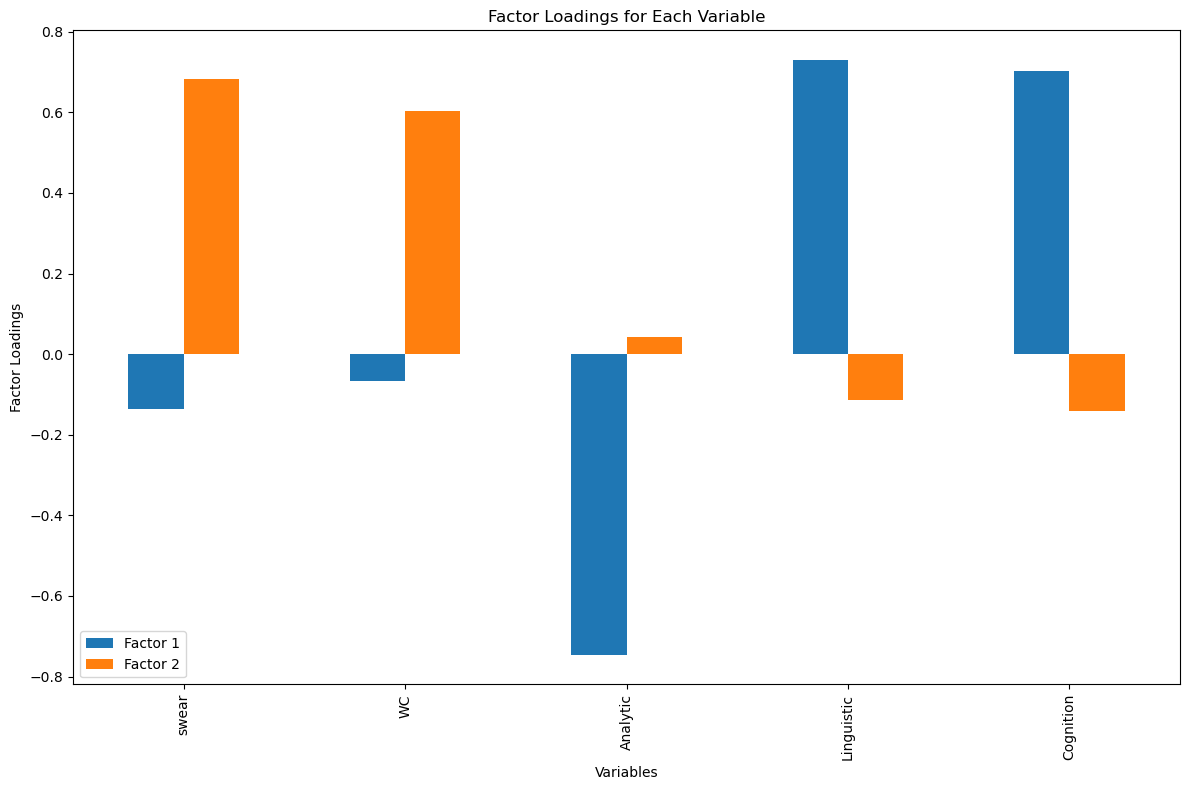

In [206]:
# look at loadings
import seaborn as sns

loadings = fa.loadings_

# Create a DataFrame for factor loadings for easier visualization
loadings_df = pd.DataFrame(loadings, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])], index=pop_num_concise.columns)
sorted_loadings_df = loadings_df.sort_values(by='Factor 2', ascending=False)


# Print factor loadings for each variable
print([sorted_loadings_df.head(10)])

# Plot bar chart of loadings for each variable in each factor
plt.figure(figsize=(10, 6))
# Set the axis limits for zooming in
sorted_loadings_df.plot(kind='bar', figsize=(12, 8))
plt.title("Factor Loadings for Each Variable")
plt.xlabel("Variables")
plt.ylabel("Factor Loadings")
plt.xticks(rotation=90)  # Rotate variable names for readability
plt.tight_layout()
plt.show()




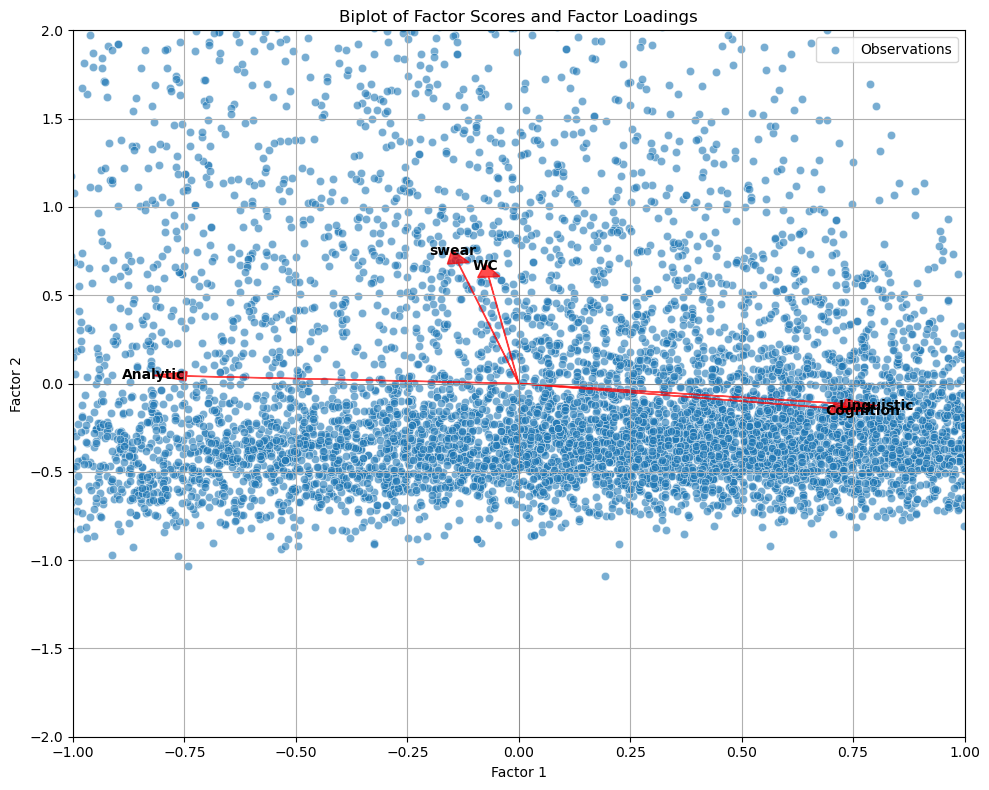

In [207]:
# look more at loadings and results: biplot
# biplot
import matplotlib.pyplot as plt
factor_scores = fa.transform(pop_num_concise)

# Create a biplot: Factor scores (observations) and factor loadings (variables)
plt.figure(figsize=(10, 8))

# Plot factor scores
sns.scatterplot(x=factor_scores[:, 0], y=factor_scores[:, 1], alpha=0.6, label='Observations')

# Plot factor loadings (arrows for variables)
for i, var in enumerate(loadings_df.index):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, var, color='black', ha='center', va='center', fontweight='bold')

# Labels and title
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
# Set the axis limits for zooming in
plt.xlim(-1, 1)
plt.ylim(-2, 2)
plt.title('Biplot of Factor Scores and Factor Loadings')
plt.axhline(0, color='gray',linewidth=0.5)
plt.axvline(0, color='gray',linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()


## K-Means: clustering of factor results

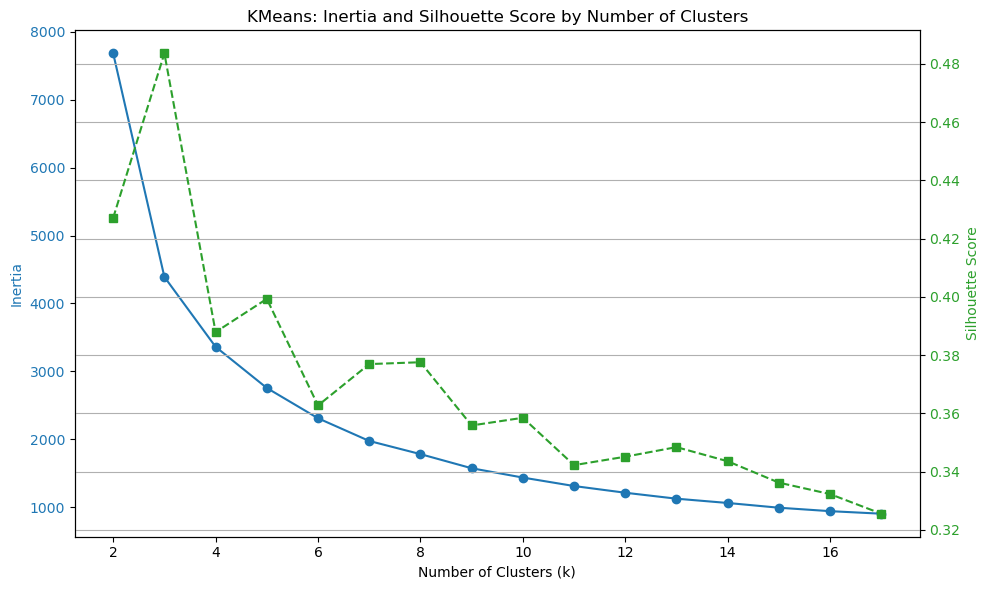

k	Inertia		Silhouette Score
2	7682.40		0.427
3	4390.13		0.484
4	3360.79		0.388
5	2754.66		0.399
6	2308.84		0.363
7	1974.49		0.377
8	1780.75		0.378
9	1572.65		0.356
10	1435.42		0.359
11	1310.82		0.342
12	1212.04		0.345
13	1124.48		0.348
14	1061.29		0.344
15	991.52		0.336
16	940.77		0.332
17	903.32		0.326


In [208]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of cluster sizes to evaluate
k_range = range(2, 18)

# Store inertia and silhouette scores
inertias = []
silhouette_scores = []

# Fit KMeans for each k and record metrics
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=13)
    kmeans.fit(factor_scores)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil_score = silhouette_score(factor_scores, labels)
    silhouette_scores.append(sil_score)

# Plot both inertia and silhouette score
fig, ax1 = plt.subplots(figsize=(10, 6))

# Inertia plot
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(k_range, inertias, marker='o', label='Inertia', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Silhouette score plot (secondary axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:green')
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='--', label='Silhouette Score', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('KMeans: Inertia and Silhouette Score by Number of Clusters')
plt.grid(True)
fig.tight_layout()
plt.show()

# Optional: Print both metrics in tabular form
print("k\tInertia\t\tSilhouette Score")
for i, k in enumerate(k_range):
    print(f"{k}\t{inertias[i]:.2f}\t\t{silhouette_scores[i]:.3f}")


In [209]:
# commit to clusters
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

kmeans_4 = KMeans(n_clusters=3, random_state=13)
clusters4 = kmeans_4.fit_predict(factor_scores)



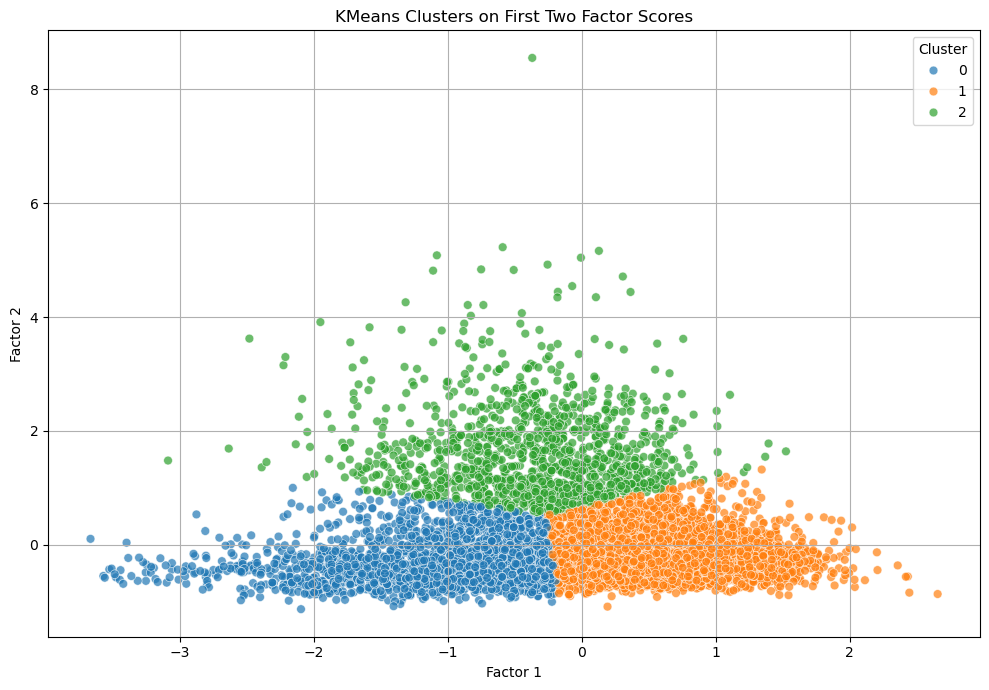

In [214]:
# visualize clusters

# Convert factor scores to a DataFrame if it's not already
factor_df = pd.DataFrame(factor_scores, columns=[f'Factor {i+1}' for i in range(factor_scores.shape[1])])
factor_df['Cluster'] = clusters4  # Add KMeans cluster labels

# Plot first two factors
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Factor 1', y='Factor 2',
    hue='Cluster',
    palette='tab10',
    data=factor_df,
    alpha=0.7,
    s=40
)
plt.title("KMeans Clusters on First Two Factor Scores")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


# # Visualize with colors
# sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=clusters5, palette="viridis", s=30)
# plt.title("UMAP of Factor Scores with Clusters")
# plt.show()

In [211]:
print(pop_num_filtered.columns)

Index(['num_days', 'avg_pos', 'max_pos', 'WC', 'Analytic', 'Clout',
       'Authentic', 'Tone', 'WPS', 'BigWords',
       ...
       'Apostro', 'OtherP', 'emotion_score', 'surprise', 'fear', 'anger',
       'joy', 'sadness', 'neutral', 'disgust'],
      dtype='object', length=127)


In [ ]:
from bertopic import BERTopic

# Step 1: Attach cluster labels to pop dataframe, ensuring alignment
pop_t =  pop_num_concise.join(pop['lyrics'], how='inner')
#pop_t['lyrics'] = pop['lyrics'].dropna()
#pop_t = pop.reset_index(drop=True)  # Ensure matching index
pop_t['Cluster'] = clusters4        # Add clusters to main dataframe

# Step 2: Initialize dictionary to store topic models per cluster
cluster_topic_models = {}

# Step 3: Loop through clusters and apply BERTopic
for cluster_id in sorted(pop_t['Cluster'].unique()):
    cluster_lyrics = pop_t[pop_t['Cluster'] == cluster_id]['lyrics'].dropna().astype(str).tolist()

    if len(cluster_lyrics) > 10:  # Skip clusters with very few entries
        print(f"\nFitting topic model for Cluster {cluster_id} with {len(cluster_lyrics)} documents...")
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(cluster_lyrics)
        cluster_topic_models[cluster_id] = topic_model

        # Optionally print top topic
        print(topic_model.get_topic_info().head(3))



Fitting topic model for Cluster 0 with 2604 documents...
   Topic  Count                           Name  \
0      0   2353              0_like_im_yeah_oh   
1      1    194              1_yeah_oh_love_im   
2      2     57  2_christmas_merry_santa_claus   

                                      Representation  \
0  [like, im, yeah, oh, love, got, its, dont, bab...   
1  [yeah, oh, love, im, that, dont, hey, me, ooh,...   
2  [christmas, merry, santa, claus, year, its, di...   

                                 Representative_Docs  
0  [(how yuh deal wid?) moment dancin' party, pus...  
1  [너는 내 삶에 다시 뜬 햇빛 어린 시절 내 꿈들의 재림 모르겠어 이 감정이 뭔지 ...  
2  [mmmh... merry christmas happy holidays merry ...  

Fitting topic model for Cluster 1 with 5408 documents...


In [ ]:
# from sklearn.neighbors import NearestNeighbors
# import matplotlib.pyplot as plt
# import numpy as np

# neigh = NearestNeighbors(n_neighbors=5)
# nbrs = neigh.fit(pop_num_concise.drop(columns=['dbscan_cluster'], errors='ignore'))
# distances, indices = nbrs.kneighbors(pop_num_concise.drop(columns=['dbscan_cluster'], errors='ignore'))

# distances = np.sort(distances[:, 4])  # 4th NN
# plt.plot(distances)
# plt.axhline(y=0.5, color='r', linestyle='--')  # current eps
# plt.title("K-distance Plot (4th NN)")
# plt.xlabel("Data Points sorted by distance")
# plt.ylabel("4th Nearest Neighbor Distance")
# plt.grid(True)
# plt.show()


In [ ]:
# # Export as df:

# # Step 1: Filter out rows with missing values in keeper columns
# pop_clusters = pop[pop[['Cognition', 'Linguistic', 'swear', 'emo_pos']].notna().all(axis=1)].copy()

# # Step 2: Add the cluster labels
# pop_clusters['cluster'] = clusters5

# # Step 3: Create the factor scores DataFrame (factor_scores should be aligned with the same filtered rows)
# factor_df = pd.DataFrame(
#     factor_scores,
#     columns=[f'Factor {i+1}' for i in range(factor_scores.shape[1])],
#     index=pop_clusters.index  # <- Use pop_clusters index here for perfect alignment
# )

# # Step 4: Concatenate factor scores into pop_clusters
# pop_clusters = pd.concat([pop_clusters, factor_df], axis=1)

# # Step 5: Check the columns
# print(pop_clusters.columns.tolist())

# # Step 6: Load the CSV file and keep only the first two columns
# songs_df = pd.read_csv('data/songs_expanded_25_04_01.csv', usecols=[0, 1])

# # Step 7: Ensure index alignment — check and align if needed
# # Option 1: If index matches pop_clusters
# # pop_clusters = pop_clusters.merge(songs_df, left_index=True, right_index=True)

# # Option 2: If there's a common key column (e.g., 'song_id' or 'title'), merge on that
# # Replace 'key_column' with the actual shared column name
# # pop_clusters = pop_clusters.merge(songs_df, on='key_column', how='left')

# # Step 7 (recommended): Add the two columns directly, assuming order matches
# pop_clusters = pop_clusters.reset_index(drop=True)  # Ensure matching index
# songs_df = songs_df.reset_index(drop=True)

# pop_clusters = pd.concat([songs_df, pop_clusters], axis=1)

# # Step 8: Check final DataFrame
# print(pop_clusters.head())


In [ ]:
# ## UMAP
# import umap
# import matplotlib.pyplot as plt

# # Initialize UMAP
# for n in [5, 15, 30, 50]:
#     embedding = umap.UMAP(n_neighbors=n, random_state=13).fit_transform(pop_num_concise)
#     plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
#     plt.title(f'n_neighbors={n}')
#     plt.show()

# # Fit and transform the factor scores
# # umap_embedding = reducer.fit_transform(factor_scores)




In [ ]:
# import numpy as np
# import pandas as pd
# import umap
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# # Set up values to test
# neighbors_range = [5,  50, 75]
# silhouette_scores = []

# for n in neighbors_range:
#     # Step 1: UMAP projection
#     reducer = umap.UMAP(n_neighbors=n, n_components=2, random_state=13)
#     embedding = reducer.fit_transform(factor_scores)  # or your high-dim data

#     # Step 2: Clustering (adjust k as needed)
#     kmeans = KMeans(n_clusters=5, random_state=13)
#     labels = kmeans.fit_predict(embedding)

#     # Step 3: Silhouette score
#     score = silhouette_score(embedding, labels)
#     silhouette_scores.append(score)

# # Step 4: Plot the results
# plt.figure(figsize=(8, 5))
# plt.plot(neighbors_range, silhouette_scores, marker='o')
# plt.title("Silhouette Score vs n_neighbors")
# plt.xlabel("UMAP n_neighbors")
# plt.ylabel("Silhouette Score")
# plt.grid(True)
# plt.show()


In [ ]:
# from umap import UMAP
# factor_cols = [col for col in pop_clusters.columns if col.startswith('Factor')]

# # Step 2: Generate UMAP embeddings
# umap_model = UMAP(random_state=13)
# umap_embedding = umap_model.fit_transform(pop_clusters[factor_cols])

# # Step 3: Plot the scatterplot with hue by cluster
# plt.figure(figsize=(12, 8))
# sns.scatterplot(
#     x=umap_embedding[:, 0],
#     y=umap_embedding[:, 1],
#     hue=pop_clusters['cluster'],
#     palette='viridis',
#     s=30,
#     alpha=0.8,
#     edgecolor='none'
# )

# # Step 4: Add artist labels (optional: limit to avoid clutter)
# for i, artist in enumerate(pop_clusters.iloc[:10, 0]):  # 
#     plt.text(
#         umap_embedding[i, 0],
#         umap_embedding[i, 1],
#         str(artist),
#         fontsize=6,
#         alpha=0.6
#     )

# plt.title("UMAP of Factor Scores with Clusters and Artist Labels")
# plt.xlabel("UMAP Dimension 1")
# plt.ylabel("UMAP Dimension 2")
# plt.legend(title='Cluster')
# plt.tight_layout()
# plt.show()

In [ ]:
# print(pop_clusters.columns.tolist())

In [ ]:
# pop_clusters.to_csv('data/songs_expandedc_25_05_12.csv', index=False)



In [ ]:
# pop_clusters.describe(include='object')
# print(pop_clusters.columns.tolist())

In [ ]:
# pop_clusters = pd.read_csv('data/songs_expandedc_25_05_12.csv') 
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# keepers = ["function", "Cognition", "cogproc", "Linguistic", "WC","Comma", "swear","Analytic",
# "Social", "socrefs", "pronoun", "ppron", "space", "Perception", "article"]
# pop_clusters = pd.get_dummies(pop_clusters, columns=['emotion'], prefix='emotion')
# pop_clusters = pd.get_dummies(pop_clusters, columns=['artist'], drop_first=False)
# pop_clusters= pop_clusters.dropna()
# drops = keepers + ['album','cluster', 'lyrics', 'song', 'Tone','lyrics-tokenized','emotion_scores_nrc', 'Factor 1', 'Factor 2']
# #X = pop_clusters.drop(columns=drops)       # Features (e.g. factor scores, PCA, etc.)
# X = pop_clusters[['surprise', 'joy', 'anger', 'neutral', 'sadness', 'fear', 'disgust', 'anger_nrc', 'fear_nrc', 'joy_nrc', 'sadness_nrc', 'surprise_nrc', 'disgust_nrc', 'trust_nrc', 'anticipation_nrc', 'negative_nrc', 'positive_nrc']]
# y = pop_clusters['cluster']    


# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# # Train model
# clf = RandomForestClassifier(random_state=13)
# clf.fit(X_train, y_train)

# # Predict on test set
# y_pred = clf.predict(X_test)

# # Evaluate performance
# print(classification_report(y_test, y_pred))

In [ ]:
# importances = clf.feature_importances_
# features = X_train.columns

# # Create a Series for easy visualization
# feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

# # Top 10 important features
# feat_importance.head(10).plot(kind='barh')
# plt.title("Top 10 Feature Importances")
# plt.gca().invert_yaxis()
# plt.show()